# Forecasting demand for multiple products using Prophet and LSTMs

### The problem statement

There are multiple product lines (teams). The Teams are A,B and C. Team C is further split into sub-teams CA, CB, CC, CD. We need to prepare a rolling 12 month forecast for each of the teams/subteams

The fiscal year spans from April to March, as well as the team targets to be achieved for each team each year. 


### The Approach

There are many different methods available to forecast univariate time series - ARIMA, Exponential Smoothing, Prophet, Deep learning models like LSTM etc. 

For this problem statement we will use Facebook's **Prophet** library. It's an easy to use package and gives reasonably good results. It also scales up to account for holidays and multivariate data when required.

Towards the end I have also demonstrated how to use a Deep Learning network like **Bidirectional LSTMs** to get even better results. It's important to have ample data when training neural networks. Since in this case we don't have too many data points so a more traditional approach like Prophet might work better

<u>Being careful with the dates</u>
<br>Since we are dealing with data which runs in the Fiscal year Apr-Mar, hence we need to ensure that the sequence remains unchanged when we feed the data into Prophet. Otherwise the Jan-Mar data would be taken prior to April, thus ruining the forecasts

<u>Evaluating the model performance</u>

We will use the following metrics to evaluate the forecasts:

1) RMSE (Root Mean Squared Error)
<br>2) RMSLE (Root Mean Squared Log Error)

The RMSLE has an advantage that unlike RMSE it is scale agnostic. So for example if our products have values in very different scales say 30, 300, 3000 etc. the RMSE values could vary like 1, 10, 100. However, the RMSLE will remain similar - 0.1, 0.1, 0.1 etc.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from monthdelta import monthdelta

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional

import warnings
warnings.filterwarnings('ignore')

Since we'll be converting from the Year = 1,2,3... to a valid year value, so taking a random Base Year for the conversions

In [99]:
BASE_YEAR = 2016

## Analyzing the data

#### Read in the data

In [100]:
df = pd.read_csv('Sample.csv', sep=';')
df.head(10)

,Team,Month,Year,Count
0,A,4,1,3
1,A,5,1,3
2,A,6,1,3
3,A,7,1,3
4,A,8,1,"67,09"
5,A,9,1,"64,31"
6,A,10,1,"67,22"
7,A,11,1,"67,22"
8,A,12,1,"61,83"
9,A,1,1,"63,39"


Let us first convert the "Count" column to valid numeric formats by replacing ',' to '.'

In [101]:
df['Count'] = df['Count'].apply(lambda x : float(x.replace(",",".")))
df.head()

,Team,Month,Year,Count
0,A,4,1,3.00
1,A,5,1,3.00
2,A,6,1,3.00
3,A,7,1,3.00
4,A,8,1,67.09


Check the basic summary and data types for the data

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Team    350 non-null    object 
 1   Month   350 non-null    int64  
 2   Year    350 non-null    int64  
 3   Count   350 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 11.1+ KB


#### Check if the CA, CB, CC, CD segments add up to the C segment

In [103]:
# Pivot the data
temp = df.pivot_table(index = ['Month','Year'], columns='Team', values='Count').reset_index()

# Calculate total of sub-segments
temp['Subsegment Total'] = temp['CA'] + temp['CB'] + temp['CC'] + temp['CD']
temp = temp[['Month','Year','CA','CB','CC','CD','Subsegment Total','C']]
temp['Difference'] = round(temp['C'] - temp['Subsegment Total'], 2)

print("Total difference between sum of segments CA,CB, CC, CD and segment C :", sum(temp['Difference']))
temp.head(15)

Total difference between sum of segments CA,CB, CC, CD and segment C : 0.0


Team,Month,Year,CA,CB,CC,CD,Subsegment Total,C,Difference
0,1,1,131.82,320.40,47.98,943.72,1443.92,1443.92,0.0
1,1,2,126.05,325.93,51.73,947.56,1451.27,1451.27,0.0
2,1,3,158.36,295.48,56.91,953.89,1464.64,1464.64,0.0
3,1,4,177.66,284.67,80.78,1002.92,1546.03,1546.03,0.0
4,2,1,131.06,317.40,48.98,952.25,1449.69,1449.69,0.0
5,2,2,154.06,322.93,52.73,937.42,1467.14,1467.14,0.0
6,2,3,0.00,293.23,58.03,952.15,1303.41,1303.41,0.0
7,2,4,179.66,286.46,80.56,1008.33,1555.01,1555.01,-0.0
8,3,1,130.06,319.40,48.98,957.06,1455.50,1455.50,0.0
9,3,2,155.06,314.40,51.73,932.76,1453.95,1453.95,0.0


We can see that the segment C is an exact sum of CA, CB, CC and CD segments at a Year/Month level. Hence we will forecast for the sub-segments and then add it up to obtain the total forecast for segment C

#### Plot the trend charts for each segment

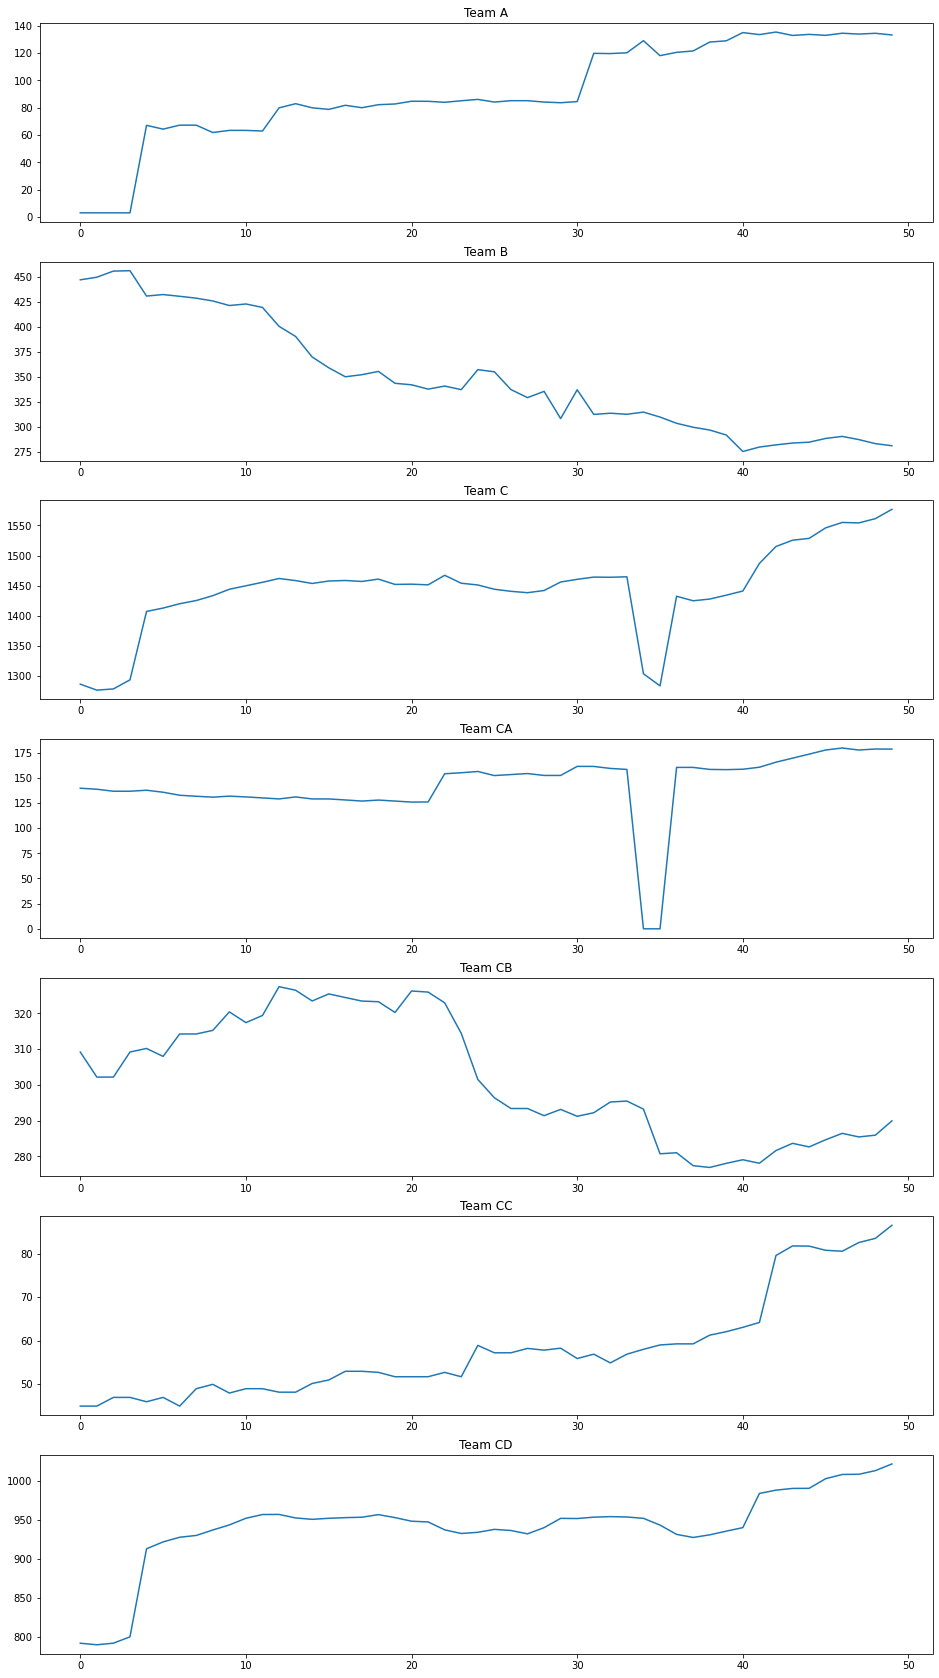

In [104]:
Teams = df['Team'].unique()

fig, ax = plt.subplots(nrows = len(Teams), ncols=1, figsize=(16,30))

for i, team in enumerate(Teams):
    data = df.loc[df['Team']==team,'Count']
    ax[i].plot(data.values)
    ax[i].set_title("Team " + team)
#     ax[i].set_x
plt.show()

The graphs show a trend for every Team. For Team "CA" there are two drastic drops where the data becomes '0' from 150. That looks like an anomaly (maybe the data is missing) and should be addressed prior to the modeling

## Forecasting the values using Prophet

#### Function to calculate the RMSE and RMSLE

In [105]:
def metrics(predicted, actual):
    
    RMSE  = round(np.sqrt(mean_squared_error(predicted, actual)),3)
    RMSLE = round(np.sqrt(mean_squared_log_error(predicted, actual)),3)
    
    return {'RMSE':RMSE, 'RMSLE':RMSLE}

#### Function to evaluate the model

This would show the actual/predicted values and print the RMSE and RMSLE scores

In [106]:
def Evaluate_Model(actual, predicted):
    
    forecast = actual[['Team','ds','y']]
    forecast = forecast.set_index('ds')
    forecast.rename(columns={'y':'Actual'}, inplace=True)
    forecast['Predicted'] = predicted['yhat'].values

    KPI = metrics(forecast['Predicted'], forecast['Actual'])

    print("\nRMSE : {}   RMSLE : {}".format(KPI['RMSE'], KPI['RMSLE']))    
    return forecast

#### Create lookup table to convert from months in Fiscal year Apr-Mar to Jan-Dec

In [264]:
Month_Lookup = {4:1, 5:2, 6:3, 7:4, 8:5, 9:6, 10:7, 11:8, 12:9, 1:10, 2:11, 3:12}
Month_Rev_Lookup = {val:key for key, val in Month_Lookup.items()}

print("Month Lookup         :",Month_Lookup)
print("Month Reverse Lookup :",Month_Rev_Lookup)

Month Lookup         : {4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 12: 9, 1: 10, 2: 11, 3: 12}
Month Reverse Lookup : {1: 4, 2: 5, 3: 6, 4: 7, 5: 8, 6: 9, 7: 10, 8: 11, 9: 12, 10: 1, 11: 2, 12: 3}


#### Function to preprocess the data for Prophet

<u>Steps for data processing</u>
  
1) Correct the Fiscal month - The dates follow the Fiscal year Apr-Mar. So our first month is April. If we don't correct that then the model could mix up the data sequence resulting in inaccurate forecasts

2) Address any data anomalies : the zeros in the Count column could be potential missing/anomalous data which would affect the prediction quality. We will fix any "0" in the Count column by forward-filling the last valid value

3) Create the columns "ds" and "y" - Prophet expects the data to have the dates in the "ds" column and the values in the "y" column

In [274]:
def Prepare_Prophet_Data(data):

    # Recalculate the month as per the fiscal calendar (Apr=1, May=2,.....,Mar=12)
    data['Month_New'] = data['Month'].map(Month_Lookup)

    # Create the 'ds' and 'y' columns as required for modeling using Prophet
    data['ds'] = data.apply(lambda x : dt.datetime(year = BASE_YEAR + x['Year'], month = x['Month_New'], day = 1), axis=1)
    data['y'] = data['Count']
    
    # Replace any '0.0' in the 'y' column using the previous value to correct for any anomalies
    data['y'] = data['y'].replace(0, np.nan)
    data['y'] = data['y'].fillna(method='ffill')
      
    return data

In [275]:
Prepare_Prophet_Data(df[df['Team'] == 'CA']).iloc[32:38,:]

,Team,Month,Year,Count,Month_New,ds,y
182,CA,12,3,159.36,9,2019-09-01,159.36
183,CA,1,3,158.36,10,2019-10-01,158.36
184,CA,2,3,0.00,11,2019-11-01,158.36
185,CA,3,3,0.00,12,2019-12-01,158.36
186,CA,4,4,160.38,1,2020-01-01,160.38
187,CA,5,4,160.38,2,2020-02-01,160.38


You can see that two of the data points for the "CA" subsegment which were '0' were corrected to have the previous valid value

### Let us test out the model for one of the segments - Team "A"

Split the data into train and test sets.

We'll use the first 3 years data for training the model, and then test it on the remaining 14 data points

In [315]:
train_size = 3 * 12
test_size = len(df) - train_size

In [316]:
# Extract the data for one of the Teams
data = Prepare_Prophet_Data(df[df['Team'] == 'A'])

# Split the data
train, test = data[:train_size], data[train_size:]

print("Train size : {} Test size : {}".format(len(train), len(test)))

Train size : 36 Test size : 14


##### Create the Prophet model

In [278]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(train)

##### Predict the forecasted values for the test set

In [279]:
pred = model.predict(test[["ds"]])
pred = np.round(pred,2)

##### Evaluate the model predictions against the actuals

In [280]:
Evaluate_Model(test, pred)


RMSE : 19.126   RMSLE : 0.156


,Team,Actual,Predicted
ds,,,
2020-01-01,A,120.55,114.31
2020-02-01,A,121.57,111.41
2020-03-01,A,128.08,102.37
2020-04-01,A,128.99,84.80
2020-05-01,A,135.01,157.93
2020-06-01,A,133.54,145.04
2020-07-01,A,135.42,146.84
2020-08-01,A,132.93,128.13
2020-09-01,A,133.70,129.53


### Let us test out the mode for another segment - Team "CA"

In [282]:
# Select the data for the subsegment
data = Prepare_Prophet_Data(df[df['Team'] == 'CA'])

# Split into train/test
train, test = data[:train_size], data[train_size:]

# Create the model
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.fit(train)

# Get the dates for future predictions
future_dates = model.predict(test[["ds"]])

# Use the model to predict
pred = model.predict(future_dates)
pred = np.round(pred,2)

# Evaluate the predictions
Evaluate_Model(test, pred)


RMSE : 15.606   RMSLE : 0.089


,Team,Actual,Predicted
ds,,,
2020-01-01,CA,160.38,181.22
2020-02-01,CA,160.38,175.06
2020-03-01,CA,158.38,172.77
2020-04-01,CA,158.16,176.42
2020-05-01,CA,158.56,181.69
2020-06-01,CA,160.56,181.47
2020-07-01,CA,165.56,174.18
2020-08-01,CA,169.56,174.86
2020-09-01,CA,173.56,177.24


## Forecast the future 12 months for all the segments

Now that we have seen that the Prophet model seems to be giving reasonable forecasts (though not great), let us use Prophet to forecast the future 12 months for each subsegment

The difference would be that since we are working with a time series where the sequence of data matters, hence for the final rolling forecasts we would NOT be splitting the data into train/test. Instead we would create the model on the full actual data for a segment and predict the next 12 months

#### Function to get the future dates for prediction

We could use the make_future_dataframe() function, but that sometimes gives incorrect results and points to the last date in the same month. Hence writing a custom function for the future dates

In [284]:
def Get_Prediction_Dates(start_date, periods):

    future_dates = []

    for i in range(1, periods+1):
        future_dates.append(start_date + monthdelta(i))

    return pd.DataFrame({"ds":future_dates})

#### Get the predictions for the next 12 months for each Team (except Team C as that created by rolling up later)

In [314]:
Teams = ['A','B','CA','CB','CC','CD']

FORECAST_PERIOD = 12

Forecasts = pd.DataFrame()


# Create the Forecasts for all the teams above
#---------------------------------------------
for team in Teams:

    print("Processing Team :", team)
    
    # Select the data for the subsegment
    data = Prepare_Prophet_Data(df[df['Team'] == team])

    # Create the model
    model = Prophet(weekly_seasonality=False, daily_seasonality=False)
    model.fit(data)

    # Get the dates for future predictions
    future_dates = Get_Prediction_Dates(data["ds"].max(), FORECAST_PERIOD)

    # Use the model to predict
    pred = model.predict(future_dates)
    pred = np.round(pred['yhat'], 2)

    Forecasts = Forecasts.append(Format_Output(future_dates, pred))

    
# Create the forecasts for Team C by aggregating the data from Teams CA, CB, CC and CD
#-------------------------------------------------------------------------------------
print("Processing Team C")
TeamC = Forecasts[Forecasts['Team'].isin(['CA','CB','CC','CD'])]
TeamC = TeamC.groupby(['Month','Year'])['Count'].sum().reset_index()

# Reformat the data in the required format, sorting the Month in the correct order required (Apr-Mar)
#----------------------------------------------------------------------------------------------------
TeamC['Month_Mapped'] = TeamC['Month'].map(Month_Lookup)
TeamC = TeamC.sort_values(['Year','Month_Mapped'])
TeamC.drop(columns=['Month_Mapped'], axis=1, inplace=True)
TeamC['Team'] = 'C'



# Create the final forecasts for all the Teams
#---------------------------------------------

Final_Forecasts = Forecasts.append(TeamC)
Final_Forecasts


Processing Team : A
Processing Team : B
Processing Team : CA
Processing Team : CB
Processing Team : CC
Processing Team : CD
Processing Team C


,Team,Month,Year,Count
0,A,6,5,142.48
1,A,7,5,140.43
2,A,8,5,161.26
3,A,9,5,159.02
4,A,10,5,161.69
...,...,...,...,...
0,C,1,5,1667.93
1,C,2,5,1681.28
2,C,3,5,1683.53
3,C,4,6,1695.93


Export the final forecasts

In [724]:
Final_Forecasts.to_csv('Forecasts.csv', index=None)

## Summary

We conclude this case study here. The objective has been to demonstrate the overall approach to forecasting using the Prophet package, not really to get the best RMSE/RMSLE. Prophet is quite easy to use and gives decent results to start with. 

We also saw how to address some of the challenges of dealing with time series data like handling missing values, working with a different Fiscal year which starts from April etc.

**What could we do better?**
<br><br>In actual practice we could use much more advanced techniques like ensembling and averaging forecasts from multiple models. We could also try using Deep Learning methods like LSTM to get better predictions

The amount of data we had was also quite less which limits the quality of the predictions. Having more data, having more granular data etc. would result in better forecasts

Below I am just demonstrating how we could use Deep Learning (LSTM) networks to forecast values and compare it with our current forecasts

### Forecasting the values using Deep learning (LSTM)

First we need to prepare the data in a format which LSTM accepts. The dimensions of the data should be of the form :
<br>(samples, timesteps, features)

In [346]:
from tensorflow.compat.v1 import set_random_seed
from tensorflow.keras.optimizers import Adam

##### Prepare the data for modeling using LSTM networks

In [320]:
def Prepare_LSTM_Data(sequence, n_steps=3):
    
    X, y = [],[]
    
    for i in range(len(sequence)):

        endpoint = i + n_steps
       
        if endpoint > len(sequence) - 1: break
            
        sub_X, sub_y = sequence[i:endpoint], sequence[endpoint]
        X.append(sub_X)
        y.append(sub_y)
    
    return np.array(X), np.array(y)

Extract the data for Team "A"

In [ ]:
data = Prepare_Prophet_Data(df[df['Team'] == 'A'])

Split the data into training and test

In [321]:
train, test = data[:train_size], data[train_size:]

Decide the size of the lookback window and the size of the output

In [328]:
# Size of lookback window
n_steps = 4  

# Size of output
n_features = 1

Prepare the data for modeling

In [324]:
X, y = Prepare_LSTM_Data(train['y'], n_steps)

for i in range(7):
    print(X[i], y[i])

[3. 3. 3. 3.] 67.09
[ 3.    3.    3.   67.09] 64.31
[ 3.    3.   67.09 64.31] 67.22
[ 3.   67.09 64.31 67.22] 67.22
[67.09 64.31 67.22 67.22] 61.83
[64.31 67.22 67.22 61.83] 63.39
[67.22 67.22 61.83 63.39] 63.39


Reshape the input in the LSTM format

In [329]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
print(X.shape)

(32, 4, 1)


Initialize the random seed so that we get consistent results on every run

In [715]:
set_random_seed(1)

##### Forecast using a LSTM model

Define the LSTM model

In [716]:
model = Sequential()
model.add(Bidirectional(LSTM(8, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))

adam_optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=adam_optimizer,loss='mse')

Fit the data to the model

In [717]:
model.fit(X,y, epochs=1000, verbose=1)

Train on 32 samples
Epoch 1/1000
32/32 [==============================] - 1s 39ms/sample - loss: 8197.6826
Epoch 2/1000
32/32 [==============================] - 0s 218us/sample - loss: 7874.3608
Epoch 3/1000
32/32 [==============================] - 0s 187us/sample - loss: 7671.6099
Epoch 4/1000
32/32 [==============================] - 0s 218us/sample - loss: 7551.0122
Epoch 5/1000
32/32 [==============================] - 0s 218us/sample - loss: 7507.0713
Epoch 6/1000
32/32 [==============================] - 0s 218us/sample - loss: 7481.5566
Epoch 7/1000
32/32 [==============================] - 0s 212us/sample - loss: 7464.7134
Epoch 8/1000
32/32 [==============================] - 0s 187us/sample - loss: 7451.8789
Epoch 9/1000
32/32 [==============================] - 0s 186us/sample - loss: 7440.7842
Epoch 10/1000
32/32 [==============================] - 0s 218us/sample - loss: 7430.0020
Epoch 11/1000
32/32 [==============================] - 0s 219us/sample - loss: 7417.8623
Epoch 12/10

Select the last point on the training data to check the prediction on a single instance

In [718]:
train.tail(5)

,Team,Month,Year,Count,Month_New,ds,y
31,A,11,3,119.81,8,2019-08-01,119.81
32,A,12,3,119.65,9,2019-09-01,119.65
33,A,1,3,120.23,10,2019-10-01,120.23
34,A,2,3,129.07,11,2019-11-01,129.07
35,A,3,3,118.13,12,2019-12-01,118.13


In [719]:
X_check = X[-1]
y_check = y[-1]

print("The test data point is :", X_check)
print("The expected forecast is :", y_check)

The test data point is : [[119.81]
 [119.65]
 [120.23]
 [129.07]]
The expected forecast is : 118.13


Reshape the data to run the prediction

In [720]:
X_check = X_check.reshape((1, X_check.shape[0], n_features))

In [721]:
pred_check = model.predict(X_check)[0][0]
print("Actual value : {}   Predicted value : {}".format(y_check, pred_check))

Actual value : 118.13   Predicted value : 123.47242736816406


We can see that the accuracy is pretty good!

But this is a data point on the training data, so it's possible the model has already learnt a lot from this data

#### Use a rolling window to forecast the data points for the test set

1) Start with the last data point on the training set
<br>2) Predict the next value (first value for the test set)
<br>3) Append the forecast it at the end of the data
<br>4) Shift the window by one step, including this last forecast data point for the next forecast
<br>5) Keep looping this process till we get all the required forecasts

In [722]:
x_seq = X[-1]
predictions = []

# Walk -forward prediction
for i in range(len(test)):
    
    x_seq = x_seq[-n_steps:]
    
    x_input = x_seq.reshape((1, n_steps, n_features))
    
    yhat = round(model.predict(x_input, verbose=0)[0][0],2)
    
    predictions.append(yhat)
    x_seq = np.append(x_seq, yhat)
    
predictions = pd.DataFrame({'yhat':predictions})

In [723]:
Evaluate_Model(test, predictions)


RMSE : 3.608   RMSLE : 0.027


,Team,Actual,Predicted
ds,,,
2020-01-01,A,120.55,123.470001
2020-02-01,A,121.57,125.669998
2020-03-01,A,128.08,126.949997
2020-04-01,A,128.99,128.240005
2020-05-01,A,135.01,127.559998
2020-06-01,A,133.54,128.589996
2020-07-01,A,135.42,129.350006
2020-08-01,A,132.93,129.990005
2020-09-01,A,133.70,130.320007


We can see that there is a dramatic improvement over the forecast quality obtained using LSTM compared to using the Prophet model

**Forecast KPIs on Team "A" using Prophet**
<br>RMSE : 19.126   RMSLE : 0.156

**Forecast KPIs on Team "A" using LSTM**
<br>RMSE : 3.608   RMSLE : 0.027

However, this is just for illustration purposes. We hardly have enough data to justify using neural networks. And it needs a lot of fine tuning to obtain good results